# Bay Trimesh

## Visualizing water depth into the Chesapeake and Delaware Bays

Many natural phenomena exhibit wide differences in the amount they vary across space, with properties varying quickly in some regions of space, and very slowly in others. These differences can make it challenging to make feasible, accurate models using a fixed sampling grid. For instance, for hydrology modelling, areas that are largely flat and uniform can be approximated with just a few samples, while areas of sharp elevation change need many samples per unit area to have a faithful representation of how water will flow.  [Datashader](http://datashader.org)'s support for irregular triangular meshes allows datasets from such simulations to be rendered onscreen efficiently. This notebook shows an example of rendering a dataset from the Chesapeake and Delaware Bay off the US Eastern coast, using data downloaded from the [Datashader examples](https://raw.githubusercontent.com/holoviz/datashader/main/examples/README.md). Once Datashader and the dataset are installed, you can run this notebook yourself to get a live version with interactive zooming for the plots that support it.

First, let's load the data file and take a look at it:

In [1]:
import datashader as ds, datashader.transfer_functions as tf, datashader.utils as du, pandas as pd

fpath = './data/Chesapeake_and_Delaware_Bays.3dm'
df = pd.read_csv(fpath, delim_whitespace=True, header=None, skiprows=1,
                 names=('row_type', 'cmp1', 'cmp2', 'cmp3', 'val'), index_col=1)

print(len(df))
tf.Images(df.head(), df.tail())

1626793


Here we have 1.6 million rows of data, some marked 'ND' (vertices defined as lon,lat,elevation) and others marked 'E3T' (triangles specified as indexes into the provided vertices, in order starting with 1 (i.e. like Matlab or Fortran, not typical Python)).

We can extract the separate triangle and vertex arrays we need for Datashader:

In [2]:
e3t = df[df['row_type'] == 'E3T'][['cmp1', 'cmp2', 'cmp3']].values.astype(int) - 1
nd  = df[df['row_type'] == 'ND' ][['cmp1', 'cmp2', 'cmp3']].values.astype(float)
nd[:, 2] *= -1 # Make depth increasing

verts = pd.DataFrame(nd,  columns=['x', 'y', 'z'])
tris  = pd.DataFrame(e3t, columns=['v0', 'v1', 'v2'])

print('vertices:', len(verts), 'triangles:', len(tris))

vertices: 560838 triangles: 1065955


We'll also precompute the combined mesh data structure, which doesn't much matter for this 1-million-triangle mesh, but would save time for plotting for much larger meshes:

In [3]:
%%time
mesh = du.mesh(verts,tris)

CPU times: user 44 ms, sys: 80.1 ms, total: 124 ms
Wall time: 123 ms


We can now visualize the average depth at each location covered by this mesh (with darker colors indicating deeper areas (higher z values, since we inverted the z values above)):

In [4]:
cvs = ds.Canvas(plot_height=900, plot_width=900)

In [5]:
%%time
agg = cvs.trimesh(verts, tris, mesh=mesh)

CPU times: user 1.8 s, sys: 28 ms, total: 1.83 s
Wall time: 1.82 s


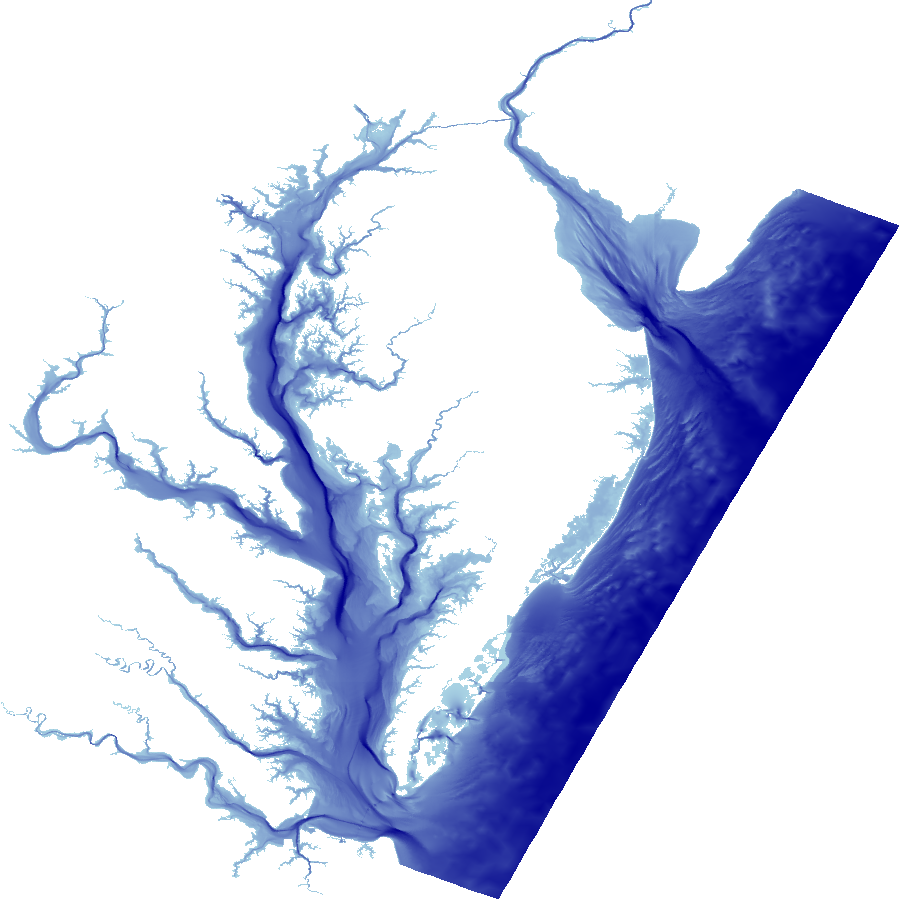

In [6]:
tf.shade(agg)

When working with irregular grids, it's important to understand and optimize the properties of the mesh, not just the final rendered data. Datashader makes it easy to see these properties using different aggregation functions:


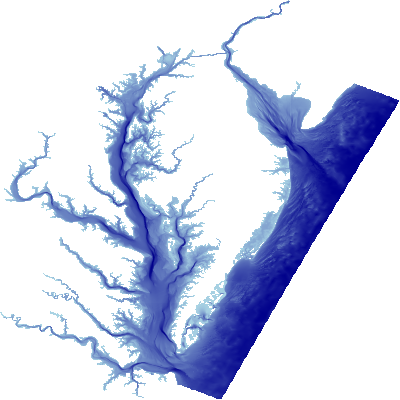
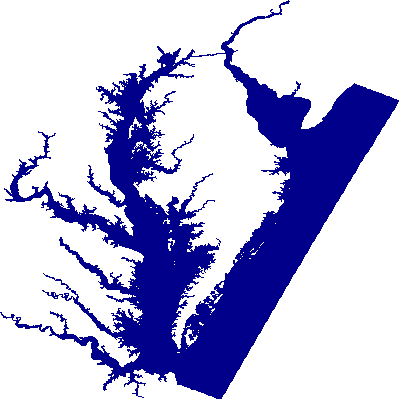
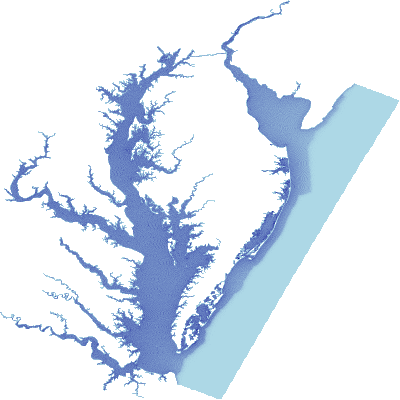
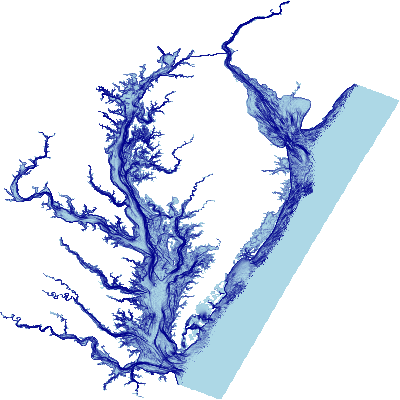

In [7]:
cvs = ds.Canvas(plot_height=400, plot_width=400)

tf.Images(tf.shade(cvs.trimesh(verts, tris, mesh=mesh, agg=ds.mean('z')), name="mean"),
          tf.shade(cvs.trimesh(verts, tris, mesh=mesh, agg=ds.any()),     name="any"),
          tf.shade(cvs.trimesh(verts, tris, mesh=mesh, agg=ds.count()),   name="count", how='linear'),
          tf.shade(cvs.trimesh(verts, tris, mesh=mesh, agg=ds.std('z')),  name="std")).cols(2)

Here "any" shows the areas of the plane that are covered by the mesh (for constructing a raster mask), "count" shows how many triangles are used in the calculation of each pixel (with few triangles in the offshore area in this case, and more around the complex inland geometry), and "std" showing how much the data varies in each pixel (highlighting regions of steep change).  "max" and "min" can also be useful for finding unexpected areas in the mesh or simulation results, e.g. deep troughs too thin to show up in the plot directly.  

Note that before calling ``tf.shade()``, the result of ``cvs.trimesh`` is just an [xarray](http://xarray.pydata.org) array, and so you can run any algorithm you want on the aggregate to do automatic checking or transformation as part of a processing pipeline.

By default, the results are bilinearly interpolated between values at each vertex, but if interpolation is turned off, the average of the values at each vertex is used for the entire triangle:


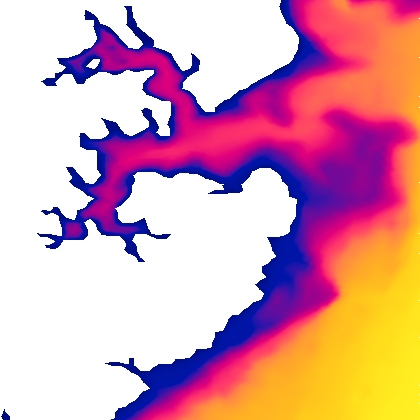
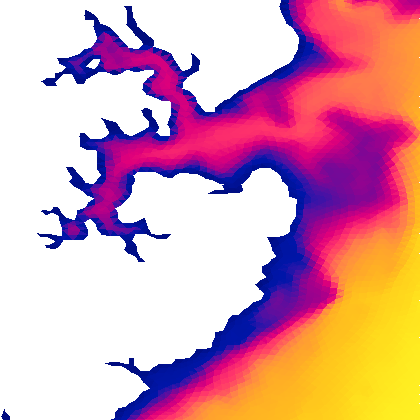

In [8]:
cvs = ds.Canvas(plot_height=420, plot_width=420, x_range=(-76.56, -76.46), y_range=(38.78, 38.902))
from colorcet import bmy as c

tf.Images(tf.shade(cvs.trimesh(verts, tris, mesh=mesh, interp=True),  cmap=c, name="Interpolated"),
          tf.shade(cvs.trimesh(verts, tris, mesh=mesh, interp=False), cmap=c, name="Raw triangles"))

## Interactivity and overlaying

Datashader only generates arrays and images, but it is designed to be integrated with plotting libraries to provide axes, interactivity, and overlaying with other data.  Visualizing the mesh as a wireframe or colored surface is simple with [HoloViews](http://holoviews.org):

ERROR 1: PROJ: proj_create_from_database: Open of /home/runner/work/examples/examples/bay_trimesh/envs/default/share/proj failed


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
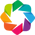

:Layout
   .DynamicMap.I  :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)
   .DynamicMap.II :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)

In [9]:
import holoviews as hv
import geoviews as gv
from holoviews import opts
from holoviews.operation.datashader import datashade

hv.extension("bokeh")
opts.defaults(
    opts.Image(width=450, height=450),
    opts.RGB(width=450, height=450))

wireframe = datashade(hv.TriMesh((tris,verts), label="Wireframe"))
trimesh = datashade(hv.TriMesh((tris,hv.Points(verts, vdims='z')), label="TriMesh"), aggregator=ds.mean('z'))
wireframe + trimesh

Here the underlying wireframe and triangles will be revealed if you enable the wheel-zoom tool and zoom in to either plot.

As you can see, HoloViews will reveal the lon,lat coordinates associated with the trimesh. However, HoloViews does not know how to reproject the data into another space, which is crucial if you want to overlay it on a geographic map in a different coordinate system.  [GeoViews](http://geo.holoviews.org) provides this projection capability if you need it:

In [10]:
opts.defaults(opts.WMTS(width=500, height=500))
tiles = gv.WMTS('https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')

In [11]:
%%time
points = gv.operation.project_points(gv.Points(verts, vdims=['z']))

CPU times: user 149 ms, sys: 7.8 ms, total: 157 ms
Wall time: 157 ms


In [12]:
tiles * datashade(hv.TriMesh((tris, points)), aggregator=ds.mean('z'), precompute=True)

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [x,y]   (R,G,B,A)

Here you can enable the wheel-zoom tool in the toolbar, then use scrolling and your pointer to zoom and pan in the plot.  As always with datashader, the data is provided to the browser in only one resolution to start with, and it will be updated when you zoom in only if you have a running Python process, and are not just viewing this on a static web page.